# Background

Citations: [1](https://arxiv.org/abs/1806.03962), [2](https://jamanetwork.com/journals/jama/fullarticle/2665774)

For my capstone project, I am using the Patch Camelyon (PCam) dataset from TensorFlow. It consists of 327,680 RGB colour images which are 96 x 96 pixels in size, totalling about 7.06 GB. These images are extracted from 400 Whole Slide Images (WSIs) of histopathologic scans of sentinel lymph nodes from breast cancer patients in the Netherlands who underwent breast cancer surgery. 

Each image is labeled as one of two classes: 
- Class 0, containing healthy lymph node tissue
- Class 1, where there is at minimum 1 pixel of metastatic cancerous tissue within the central 32 x 32 pixel region of the image

The motivation for this type of analysis is relatively straightforward. Breast cancer (and other cancer) advances through stages from 0 to 4 as the disease progresses in severity. As shown in the image below, cancer begins to spread to the lymph nodes during Stage 2, at which point the 5 year survival rate of the patient begins to drop rapidly:

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://media.sciencephoto.com/image/f0317403/800wm/F0317403-Breast_Cancer_Stages,_Illustration.jpg")

The closest lymph node to the tumour is called the sentinel lymph node, and this is the first place where cancer cells will be detected when the cancer begins to metastasize, or spread, beyond the original tumour. It is critical to diagnose Stage 2 cancer as early as possible because the cancer becomes more difficult to detect and to treat as it spreads, and requires more aggressive treatments such as further surgery, radiation, and chemotherapy.

Typically, histopathologic lymph node samples are examined under a microscope by a medical pathologist, a doctor who has undergone 5 years of specialized training during their residency to become qualified to do this kind of work. This process is time-consuming and prone to error, and applying machine learning techniques such as Convolutional Neural Networks (CNNs) provides an opportunity to reduce the workload of pathologists and to improve patient outcomes by pre-screening these slides.

In order to provide a baseline for the performance of the models I will be analyzing, I propose three levels of performance to compare against.

The first is simply whether the model performs better than a random guess based on the class distribution. Based on the [description of the data](https://github.com/basveeling/pcam), the class distribution is very close to 50/50, so predicting more than 50% of the samples correctly by simply predicting the same result for all of the images represents the bare minimum level of performance.

Second is the performance of the [11 pathologists](https://jamanetwork.com/journals/jama/fullarticle/2665774) who participated in a study on the PCam dataset. The pathologists were evaluated on the Area Under the Curve (AUC) of their Reciever Operating Characteristic (ROC), which is a measure of the true positive rate and false positive rate of their diagnosis when plotted against various decision thresholds. When operating under a 2 hour time constraint which simulates a routine pathology workflow, the best pathologist achieved an AUC of 0.884, while the mean for the group was 0.810 AUC. Worth noting is one pathologist who was given no time constraints achieved an AUC of 0.966, but spent 30 hours on their analysis which is not representative of a typical workflow.

Finally, the researchers of the paper who tested the pathologists achieved an astounding AUC of 0.994 with their best algorithm. This represents the absolute upper bound of the algorithmic approach to this problem and is not likely to be achievable with my limited time and expertise.

In my project, I aim to achieve an AUC greater than 0.810 which was the mean of the pathologists who operated under a time contraint.

---

# Exploratory Data Analysis (EDA)

To begin the EDA process, I'll load the dataset and take a look at some of the images.

In [7]:
# pcamlib is my library of helper functions
import pcamlib
import pandas as pd

In [3]:
pcam, pcam_info = pcamlib.load_pcam()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jaredlauer/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable

The dataset is split into the following categories:

- Training Set: 262,144 images (80% of total images)
- Validation Set: 32,768 images (10% of total images)
- Test Set: 32,768 images (10% of total images)

In [14]:
%%time
y_true_train = pd.Series(pcamlib.generate_y_true(pcam, 'train'))

CPU times: user 3min 24s, sys: 21.6 s, total: 3min 46s
Wall time: 54.6 s


In [15]:
y_true_train.value_counts(normalize=True)

0    0.5
1    0.5
dtype: float64

Training set:
- 50.0% Class 0
- 50.0% Class 1

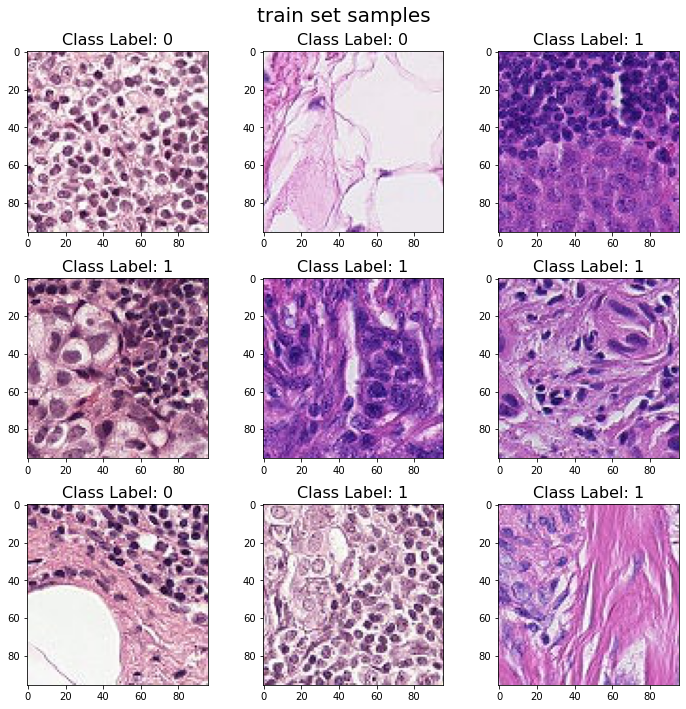

In [4]:
# Show samples of the training set
pcamlib.plot_examples(pcam, 'train')

In [16]:
%%time
y_true_validation = pd.Series(pcamlib.generate_y_true(pcam, 'validation'))

CPU times: user 25.9 s, sys: 2.69 s, total: 28.6 s
Wall time: 5.88 s


In [17]:
y_true_validation.value_counts(normalize=True)

0    0.500458
1    0.499542
dtype: float64

Validation set:
- 50.0458% Class 0
- 49.9542% Class 1

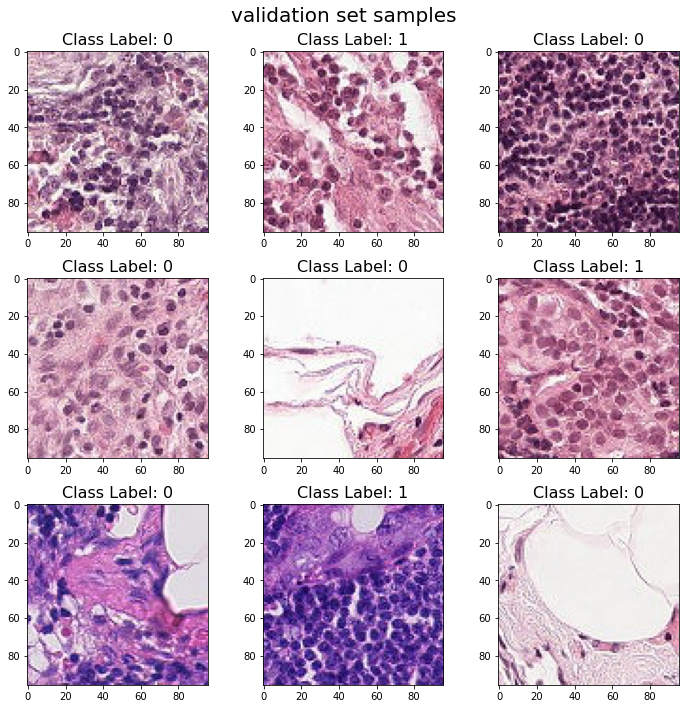

In [5]:
# Show samples of the validation set
pcamlib.plot_examples(pcam, 'validation')

In [18]:
%%time
y_true_test = pd.Series(pcamlib.generate_y_true(pcam, 'test'))

CPU times: user 26 s, sys: 2.69 s, total: 28.7 s
Wall time: 5.91 s


In [19]:
y_true_test.value_counts(normalize=True)

0    0.500214
1    0.499786
dtype: float64

Test set:
- 50.0214% Class 0
- 49.9786% Class 1

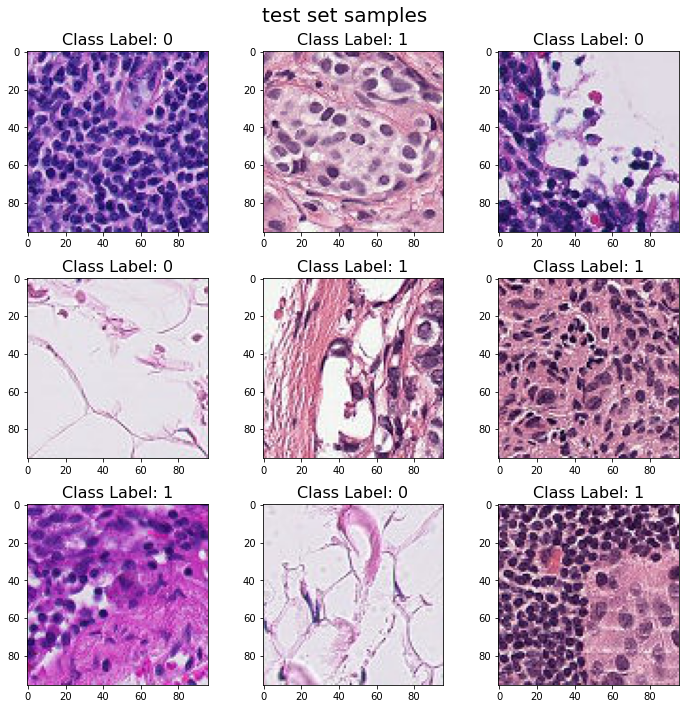

In [6]:
# Show samples of the test set
pcamlib.plot_examples(pcam, 'test')

After reviewing some of these sample images, it's obvious that it is extremely difficult as a layperson to accurately identify which samples contain cancer tissue and which do not. At times, we can make certain assumptions that when there is a clear border of two different types of cells (such as in the bottom right corner of the test set above) that may represent cancer. But following that type of logic is risky, as there are other samples which I thought were cancerous (such as the bottom left corner of the validation set), which are actually comprised of healthy tissue.